In [16]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import sqlite3 
import os
import matplotlib.pyplot as plt
from PIL import Image
import glob
from html import escape
from datetime import datetime
%matplotlib inline

category_map = {
    '100': '정치',
    '101': '경제',
    '102': '사회',
    '103': '생활/문화',
    '104': '세계',
    '105': 'IT/과학',
    '106': '연예',
    '107': '스포츠'
}

def convert_date_format(original_date):
    if '오전' in original_date:
        original_date = original_date.replace('오전', 'AM')
        is_pm = False
    elif '오후' in original_date:
        original_date = original_date.replace('오후', 'PM')
        is_pm = True

    dt = datetime.strptime(original_date, '%Y.%m.%d. %p %I:%M')

    # 오후 시간을 24시간 형식으로 변환 (단, 오후 12시는 제외)
    if is_pm and dt.hour < 12:
        dt = dt.replace(hour=dt.hour + 12)

    return dt.strftime('%Y-%m-%d %H:%M:%S')


def get_category_from_url(url):
    # URL에서 sid 값을 추출
    sid = url.split('sid=')[1] if 'sid=' in url else None
    return category_map.get(sid, '기타')  # sid가 매핑 딕셔너리에 없는 경우 '기타' 카테고리 반환

def news_crawl(query, start_date, end_date, sort_type, max_page):
    dbpath = "news_info.db" 
    conn = sqlite3.connect(dbpath)
    cur = conn.cursor() 

    script = """
    DROP TABLE IF EXISTS news_crawl;

    CREATE TABLE news_crawl(
      id INTEGER PRIMARY KEY AUTOINCREMENT,  -- 뉴스의 ID 값
      date TEXT,                             -- 뉴스의 작성일
      title TEXT,                            -- 뉴스의 제목
      summary TEXT,                          -- 뉴스의 요약
      link TEXT,                             -- 뉴스의 원문 링크
      naver_link TEXT,                       -- 뉴스의 네이버 링크
      content TEXT,                          -- 뉴스의 본문 내용
      press TEXT,                            -- 뉴스의 언론사
      category TEXT                          -- 뉴스의 카테고리
    );
    """
    cur.executescript(script)
    cur.execute("SELECT link FROM news_crawl")
    existing_links = {row[0] for row in cur.fetchall()}
        
    if query == '':
        query = '데이터 분석'
    if len(start_date) != 10:
        start_date = '2024.01.14'
    if len(end_date) != 10:
        end_date = '2024.01.17'
    if sort_type not in ['0', '1', '2']:
        sort_type = '0'
#     start_date = start_date.replace(".", "")
#     end_date = end_date.replace(".", "")
    start_page=1

    headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'}

    for page in range(1, max_page + 1):
        start = 1 + (page - 1) * 10  # 페이지에 따른 시작 기사 번호 계산
        url = f"https://search.naver.com/search.naver?where=news&query={query}&sm=tab_opt&sort={sort_type}&photo=0&field=0&reporter_article=&pd=3&ds={start_date}&de={end_date}&docid=&nso=so:r,p:from{start_date}to{end_date},a:all&mynews=0&refresh_start=0&related=0&start={start}"
 
        web = requests.get(url, headers=headers).content
        source = BeautifulSoup(web, 'html.parser')

        # 각 페이지 내의 모든 뉴스 기사를 순회합니다.
        for article in source.find_all('div', {'class': 'news_area'}):
            title = article.find('a', {'class': 'news_tit'}).get('title').replace("'", "''")
            link = article.find('a', {'class': 'news_tit'}).get('href').replace("'", "''")
            summary = article.find('a', {'class': 'api_txt_lines dsc_txt_wrap'}).get_text().replace("'", "''")
            naver_url = ""
            if link not in existing_links:
                existing_links.add(link)  # 링크 집합에 추가
            #네이버 뉴스에 등록된 뉴스만 사용
            for urls in article.find_all('a', {'class': 'info'}):
                if urls["href"].startswith("https://n.news.naver.com"):
                    naver_url = urls["href"].replace("'", "''")
                    break
            if naver_url:
                category = get_category_from_url(naver_url)
                response = requests.get(naver_url, headers=headers)
                soup = BeautifulSoup(response.content, 'html.parser')
                # 언론사명 추출
                press_company_tag = soup.find('em', {'class':'media_end_linked_more_point'})
                press_company = press_company_tag.get_text() if press_company_tag else "언론사 정보 없음"
                date_text_tag = soup.find('span', {'class' : 'media_end_head_info_datestamp_time'})
                date_text = date_text_tag.get_text() if date_text_tag else "날짜 정보 없음"
                if date_text != "날짜 정보 없음":
                    formatted_date = convert_date_format(date_text)
                else:
                    formatted_date = "날짜 형식 변환 실패"
                #formatted_date = convert_date_format(date_text)
                content_area = soup.find(id='dic_area')
                news_content = content_area.get_text(strip=True).replace("'", "''") if content_area else "본문을 찾을 수 없습니다."
                news_content = escape(news_content)

                base_sql = "INSERT INTO news_crawl(date, title, summary, link, naver_link, content, press, category) values('{}', '{}', '{}', '{}', '{}', '{}', '{}', '{}')"
                sql_query = base_sql.format(formatted_date, title, summary, link, naver_url, news_content, press_company, category)
                cur.execute(sql_query)
                conn.commit()
            else:
                print(f"중복된 뉴스 건너뜀: {title}")
            

    conn.close()

# 사용자 입력을 통한 크롤링 실행
query = input('크롤링하고 싶은 뉴스 검색어를 입력해주세요: ')
start_date = input('크롤링하고 싶은 뉴스의 시작 날짜를 입력해주세요(ex:2024.01.01): ')
end_date = input('크롤링하고 싶은 뉴스의 종료 날짜를 입력해주세요(ex:2024.01.01): ')
sort_type = int(input('크롤링하고 싶은 뉴스의 정렬방법을 입력해주세요(관련도순 = 0  최신순 = 1  오래된순 = 2): '))
max_page = int(input('크롤링하고 싶은 뉴스의 페이지 수를 입력해주세요: '))
news_crawl(query, start_date, end_date, sort_type, max_page)


크롤링하고 싶은 뉴스 검색어를 입력해주세요: 한국
크롤링하고 싶은 뉴스의 시작 날짜를 입력해주세요(ex:2024.01.01): 2024.01.01
크롤링하고 싶은 뉴스의 종료 날짜를 입력해주세요(ex:2024.01.01): 2024.01.25
크롤링하고 싶은 뉴스의 정렬방법을 입력해주세요(관련도순 = 0  최신순 = 1  오래된순 = 2): 1
크롤링하고 싶은 뉴스의 페이지 수를 입력해주세요: 170
중복된 뉴스 건너뜀: 역전골 허용한 한국
중복된 뉴스 건너뜀: 정우영 선제골로 앞서가는 한국 대표팀
중복된 뉴스 건너뜀: 졸전 벌인 한국, 말레이와 3-3 무승부…16강 한일전 무산(종합)
중복된 뉴스 건너뜀: 한국, ''130위'' 말레이와 3-3 무승부…아시안컵 16강 한일전 무산
중복된 뉴스 건너뜀: 한국, ''130위'' 말레이와 3-3 무승부…아시안컵 16강 한일전 무산(종합)
중복된 뉴스 건너뜀: 동점골 허용한 한국
중복된 뉴스 건너뜀: [청소년올림픽] 스노보드 이채운 금메달…한국, 빙속·아이스하키서 은 2개 추가
중복된 뉴스 건너뜀: 역전 당한 한국대표팀
중복된 뉴스 건너뜀: ''정우영 선제골'' 한국, 말레이에 1-0…조 1위 가능성↑(전반 종료)
중복된 뉴스 건너뜀: 경기장 들어선 한국 대표팀
중복된 뉴스 건너뜀: 역전 성공시킨 한국
중복된 뉴스 건너뜀: 한국 상대로 명승부 펼친 김판곤 감독
중복된 뉴스 건너뜀: 이강인, 한국 살린 ''황금 프리킥'', 부진 ''잠시뿐''이었다
중복된 뉴스 건너뜀: 한국 썰매 유망주들 ‘희망’을 쐈다
중복된 뉴스 건너뜀: 한국-말레이시아전 대상 프로토 승부식 12회차 발매 중
중복된 뉴스 건너뜀: PGA 투어 ''한국 군단''… 파머스 인슈어런스 오픈 1R ''불안한 출발''
중복된 뉴스 건너뜀: [속보] 한국 ''우여곡절'' 2위, F조 1위와 8강 다툼...16강 한일전 ''불발''
중복된 뉴스 건너뜀: [아시안컵] 말레이 김판곤 감독 "환상적인 결과 수확…한국 우승 기원"
중복된 뉴스 건너뜀: 한국, 말레이시

중복된 뉴스 건너뜀: 스포츠토토, 한국-말레이시아전 대상 프로토 승부식 12회차 발매
중복된 뉴스 건너뜀: 한국은행, 다음달 9조원 규모 통화안정증권 발행
중복된 뉴스 건너뜀: 한국 여자축구 간판 지소연, 美 시애틀 입단…"검증된 승리자"
중복된 뉴스 건너뜀: 尹대통령, 아제이 방가 세계은행 총재 만나...“세계은행과 한국 윈-윈 협력할 것”
중복된 뉴스 건너뜀: 한국에너지공대 김동철 이사장, 발전방안 의견 청취 교수 간담회
중복된 뉴스 건너뜀: "부진·변동성·불안정성·양극화"…복합위기 한국경제
중복된 뉴스 건너뜀: 강원청소년올림픽 한국 여자 아이스하키 값진 은메달
중복된 뉴스 건너뜀: 한국타이어, 모터스포츠 다큐 ‘The First’ 공개
중복된 뉴스 건너뜀: 말 복지 확대하는 한국마사회, 동물보호와 생명존중 가치 구현
중복된 뉴스 건너뜀: [썰물밀물] 난장판 한국 정치
중복된 뉴스 건너뜀: 한국, 女 3X3 아이스하키, 중국 제압하고 결승 진출…사상 첫 메달 확보
중복된 뉴스 건너뜀: 클린스만과 달랐던 김판곤 감독 “한국은 우승할 수 있는 팀” [아시안컵]
중복된 뉴스 건너뜀: 한투운용 ‘멀티에셋 투자 ETF’ 2종, 수익률 TOP2 석권
중복된 뉴스 건너뜀: 작년 한국경제 1.4% 성장... 반도체 수출 회복에 4분기 0.6%↑
중복된 뉴스 건너뜀: CJ올리브영, 한국콜마와 ''바이오힐 보'' 화장품 키운다
중복된 뉴스 건너뜀: 한국 아이스하키, 결승 진출…헝가리와 격돌
중복된 뉴스 건너뜀: [카타르 현장리뷰] 한국 충격의 조 2위! 105분 극장골 허용... 한일전 없다, ''130위'' 말레이와 3-3 무승부
중복된 뉴스 건너뜀: 북한 “신형 전략순항미사일 시험발사”…한국 합참 “기존 기종 성능 개량”
중복된 뉴스 건너뜀: [속보] 한국 손흥민 이강인 김민재 황인범 ''선발'', 말레이시아전 ''정상 가동''
중복된 뉴스 건너뜀: 알나스르, 방중 경기 취소…''한국서 노쇼'' 호날두, 중국엔 사과
중복된 뉴스 건너뜀: ''요르단 쇼크 탓?'' 한국, 

중복된 뉴스 건너뜀: 한국타이어, 자체 제작 레이싱 도전기…''더 퍼스트'' 티빙 공개
중복된 뉴스 건너뜀: [인사] 한국산업은행
중복된 뉴스 건너뜀: 바이오힐 보-한국콜마, ''프로바이오 랩'' 설립
중복된 뉴스 건너뜀: 개혁신당-한국의희망 합당 선언..제3지대 연대 본격화
중복된 뉴스 건너뜀: 한국거래소 신임 이사장에 정은보 추대…이사회 통과
중복된 뉴스 건너뜀: 한국 진출 확대 나서는 ''우시XDC''…ADC 파트너링 행보 활발
중복된 뉴스 건너뜀: ''이것이 한국 첫 아이스하키 올림픽 메달''
중복된 뉴스 건너뜀: 한국타이어, 모터스포츠 다큐 ''더 퍼스트'' 티빙서 단독 공개
중복된 뉴스 건너뜀: 한국타이어, 모터스포츠 다큐 ''더 퍼스트'' 티빙서 단독 공개
중복된 뉴스 건너뜀: 지난해 한국 경제 1.4% 성장…수출 회복에 4분기 0.6%↑
중복된 뉴스 건너뜀: 한국고용정보원 및 한국장학재단, 총 27만여 명 개인정보 유출
중복된 뉴스 건너뜀: 인사] 한국가스안전공사(간부)
중복된 뉴스 건너뜀: 한국 솔가, 해외직구 플랫폼 블루존 경쟁력 강화
중복된 뉴스 건너뜀: [도하 현장] ''16강 한일전'' 성사 임박!…한국 1-0 말레이, 바레인 1-0 요르단 (전반 종료)
중복된 뉴스 건너뜀: 한국-말레이시아전 손·이·김 ''트로이카'' 선발..황희찬 벤치에
중복된 뉴스 건너뜀: CJ올리브영, 한국콜마와 협약…프로바이오 연구소 설립
중복된 뉴스 건너뜀: 한국마사회, 말 산업 국가인적자원개발컨소시엄 교육과정 운영
중복된 뉴스 건너뜀: 한국해양진흥공사법 시행령 오늘부터 발효
중복된 뉴스 건너뜀: [아시안컵] 한국, 말레이시아전 선발 명단 발표...최전방 조규성
중복된 뉴스 건너뜀: 한국 상대하는 말레이 김판곤 감독 "우린 잃을 게 없다, 싸우겠다"
중복된 뉴스 건너뜀: 한국에너지공대 김동철 이사장, 한국에너지공과대학 발전방안 의견 청취를 위한 교수 간담회 개최
중복된 뉴스 건너뜀: ''랭킹 130위'' 말레이시아에 동점골 허용...한국, 조별리그 모든 경기 

중복된 뉴스 건너뜀: 개혁신당 이준석·한국의희망 양향자 ''합당'' 선언
중복된 뉴스 건너뜀: "클린스만호 더 좋아질 것, 결승서 보자"…한국 잊지 않은 벤투 사단 [아시안컵]
중복된 뉴스 건너뜀: 한국 3-3 말레이시아(경기 종료)
중복된 뉴스 건너뜀: [포토] 개혁신당-한국의희망 합당 발표
중복된 뉴스 건너뜀: [속보] 한국 말레이시아 축구중계, 말레이시아 극적 동점골 3-3
중복된 뉴스 건너뜀: 한국·체코·영국, ‘중국 인권검토’서 탈북민 북송 문제 제기
중복된 뉴스 건너뜀: 한국농어촌공사 파주지사, 청년농 농지지원사업 소통간담회 개최
중복된 뉴스 건너뜀: CJ올리브영, 바이오힐 보-한국콜마와 MOU 체결
중복된 뉴스 건너뜀: 한국해양진흥공사, ''한국해양진흥공사법 시행령'' 개정 시행
중복된 뉴스 건너뜀: 지구촌 지진·전쟁 난민의 ...수호천사 한국 카리타스
중복된 뉴스 건너뜀: 지구촌 지진·전쟁 난민의 ...수호천사 한국 카리타스
중복된 뉴스 건너뜀: CJ올리브영‧한국콜마, 손잡고 스킨케어 화장품 글로벌 시장 공략
중복된 뉴스 건너뜀: 한국부동산원, 부동산개발 전문인력 교육생 모집
중복된 뉴스 건너뜀: 한국부동산원, 부동산개발 전문인력 교육생 모집
중복된 뉴스 건너뜀: 한국거래소, 신임 이사장에 정은보 전 금감원장 추대
중복된 뉴스 건너뜀: 한국해양진흥공사, 해양진흥공사법 시행령 시행…신규 사업 추가
중복된 뉴스 건너뜀: 제3지대 ''한국의희망+개혁신당'' 합당 선언
중복된 뉴스 건너뜀: 세계평화연합, 철학자 김형석 교수 초청 신한국포럼 개최
중복된 뉴스 건너뜀: [속보] 한국 말레이시아 축구중계, 전반 21분 정우영 헤딩골 1-0
중복된 뉴스 건너뜀: CJ올리브영 바이오힐 보, 한국콜마 바이오 성분 전문 연구소 설립
중복된 뉴스 건너뜀: 말 복지 확대하는 한국마사회, 동물보호와 생명 존중 가치 구현 눈길
중복된 뉴스 건너뜀: 한국산업단지공단, 방글라데시 PKSF와 산단 사업 경험 공유
중복된 뉴스 건너뜀: [인사] 한국가스안전공사, 한국수력원자력, 

중복된 뉴스 건너뜀: 한국영상대, 네트워킹데이 개최
중복된 뉴스 건너뜀: 한국서 ‘노쇼’에 말 없던 호날두, 방중 경기 취소에 “미안하다”
중복된 뉴스 건너뜀: 한국종합기술, 강원 양양에 인재 육성 기금 기탁
중복된 뉴스 건너뜀: 한국마사회, 부상마 진료지원 복지사업 전개…''생명존중'' 가치 구현
중복된 뉴스 건너뜀: ''아시안컵'' 한국축구대표팀, 말레이시아 최종전 3-3 ''또 무승부''… 조 2위
중복된 뉴스 건너뜀: 개혁신당·한국의희망 ''합당''… "서로의 비전과 가치 동의"
중복된 뉴스 건너뜀: ''한국반도체''가 뿌린 씨앗… 반세기뒤 수출 1천억불 결실
중복된 뉴스 건너뜀: 작년 한국 경제성장률 3년 만에 최저...새해에도 곳곳이 ‘암초’
중복된 뉴스 건너뜀: ''메달리스트들의 셀카''
중복된 뉴스 건너뜀: MLB 세인트루이스, 한국계 에드먼과 연봉조정 피해 2년 계약
중복된 뉴스 건너뜀: 한국타이어, 사계절용 컴포트 타이어 ''키너지 XP'' 북미 출시
중복된 뉴스 건너뜀: 한국에 두고 떠난 ‘전생’…오스카 주목받은 셀린 송
중복된 뉴스 건너뜀: CJ올리브영, 한국콜마와 기술협력·마케팅 MOU
중복된 뉴스 건너뜀: 한국, 13개월 만에 A매치 3+ 실점...그 상대가 ''130위'' 말레이시아라니
중복된 뉴스 건너뜀: 한국타이어, 모터스포츠 다큐 ''The First'' 티빙 공개로 기술력 알려
중복된 뉴스 건너뜀: [LPGA 루키 특집 ①] 꿈을 위해 슈퍼 루키로 변신한 한국 선수 셋
중복된 뉴스 건너뜀: 한국거래소 이사회, 신임 이사장에 정은보 전 금감원장 결의
중복된 뉴스 건너뜀: 한국고용정보원·한국장학재단의 개인정보 유출 제재 수위는? 각 840만원 과태료 부과
중복된 뉴스 건너뜀: 한국중부발전 ''따뜻한 겨울나기 지원사업'' 기부금 전달식 개최
중복된 뉴스 건너뜀: [아시안컵] 한국 우승확률 11.5% 5위로 급락... 15.6% 호주 1위
중복된 뉴스 건너뜀: 바이오힐 보-한국콜마, 마이크로바이옴 기술 협력 MOU
중복된 뉴스 건너뜀

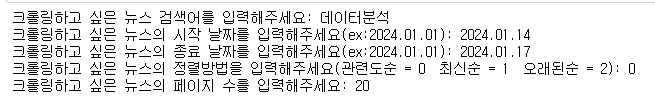  
이와 같이 크롤링 옵션을 입력합니다. 네이버 뉴스에 등록된 뉴스만 크롤링 하도록 설정되어 있습니다.

In [17]:
#데이터 저장
import pandas as pd
import sqlite3

# 데이터베이스에서 데이터 읽기
conn = sqlite3.connect('news_info.db')
query = "SELECT * FROM news_crawl"
df = pd.read_sql_query(query, conn)
conn.close()

# 원하는 카테고리 필터링
selected_categories = ['정치', '경제', '사회', '생활/문화', 'IT/과학']
filtered_df = df[df['category'].isin(selected_categories)]

# 필터링된 데이터를 CSV 파일로 변환
csv_file_path_2 = "news_data_2.csv"
filtered_df.to_csv(csv_file_path_2, index=False, encoding='utf-8-sig')

# 데이터를 CSV 파일로 변환
csv_file_path = "news_data.csv"
df.to_csv(csv_file_path, index=False, encoding='utf-8-sig')

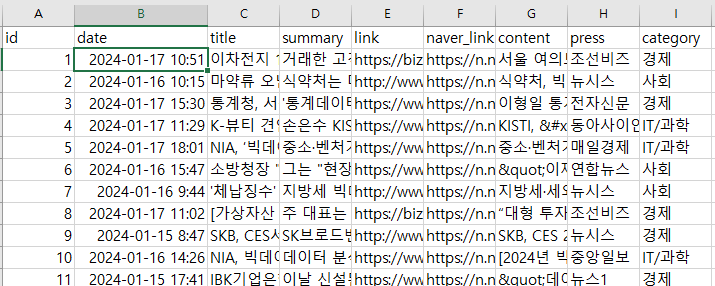
  
CSV로 저장시 위와 같은 형태로 저장됩니다.

In [12]:
#뉴스 필터
def filter_news_data(start_date, end_date, press_name):
    conn = sqlite3.connect('news_info.db')
    query = """
    SELECT * FROM news_crawl 
    WHERE date BETWEEN ? AND ? AND press LIKE ?
    """
    params = (start_date, end_date, f'%{press_name}%')
    filtered_data = pd.read_sql_query(query, conn, params=params)
    conn.close()
    return filtered_data

In [14]:
#html + gpt api
from flask import Flask, request, jsonify, render_template
import sqlite3
import html
from openai import OpenAI
import os
from dotenv import load_dotenv

app = Flask(__name__)

# API 키를 env파일에서 읽기
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY") 
client = OpenAI(api_key=api_key)

def generate_gpt_content(news_content, summary_limit, title_limit, language, user_request):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"'{news_content}' 위 내용을 바탕으로 {language}로 개선된 뉴스본문을 작성해. 그리고 {summary_limit}자 이내의 요약과 {title_limit}자 이내의 제목도 생성해. 반드시 뉴스본문 앞에는 gpt_content: 를 요약 앞에는 gpt_summary: 를, 제목 앞에는 gpt_title: 을 붙여.{user_request}"
            },
        ]
    )
    return response.choices[0].message.content

@app.route('/')
def show_news(): #필터링 뉴스
    # 필터링 조건을 정의합니다.
    start_date = '2024-01-24'  # 예시 날짜
    end_date = '2024-01-26'    # 예시 날짜
    press_name = '%뉴시스%'      # 예시 언론사 이름

    # filter_news_data 함수를 호출하여 필터링된 데이터를 가져옵니다.
    filtered_data = filter_news_data(start_date, end_date, press_name)
    news_data_as_list = filtered_data.values.tolist()

    return render_template('news_template.html', news_data=news_data_as_list)

# def show_news(): #전체 뉴스
#     # 데이터베이스에서 전체 뉴스 데이터를 가져옵니다.
#     conn = sqlite3.connect('news_info.db')
#     cur = conn.cursor()
#     cur.execute("SELECT * FROM news_crawl")
#     news_data = cur.fetchall()
#     conn.close()

#     # HTML 템플릿에 데이터를 직접 전달합니다.
#     return render_template('news_template.html', news_data=news_data)

@app.route('/process', methods=['POST'])

def process():
    news_content = request.form['content']
    summary_limit = int(request.form.get('summary_limit', '50'))
    title_limit = int(request.form.get('title_limit', '30'))
    language = request.form.get('language', '한국어')  # 기본값은 한국어
    user_request = request.form.get('user_request', '')  # 기본값은 빈 문자열
    decoded_content = html.unescape(news_content)
    app.logger.info('Received content: %s', decoded_content)
    gpt_response = generate_gpt_content(decoded_content, summary_limit, title_limit, language, user_request)


    return jsonify({'gpt_result': gpt_response})

if __name__ == '__main__':
    app.run(debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [26/Jan/2024 19:53:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Jan/2024 19:53:05] "GET /static/style.css HTTP/1.1" 304 -


셀을 실행하면 http://127.0.0.1:5000 에 html이 표시됩니다.    

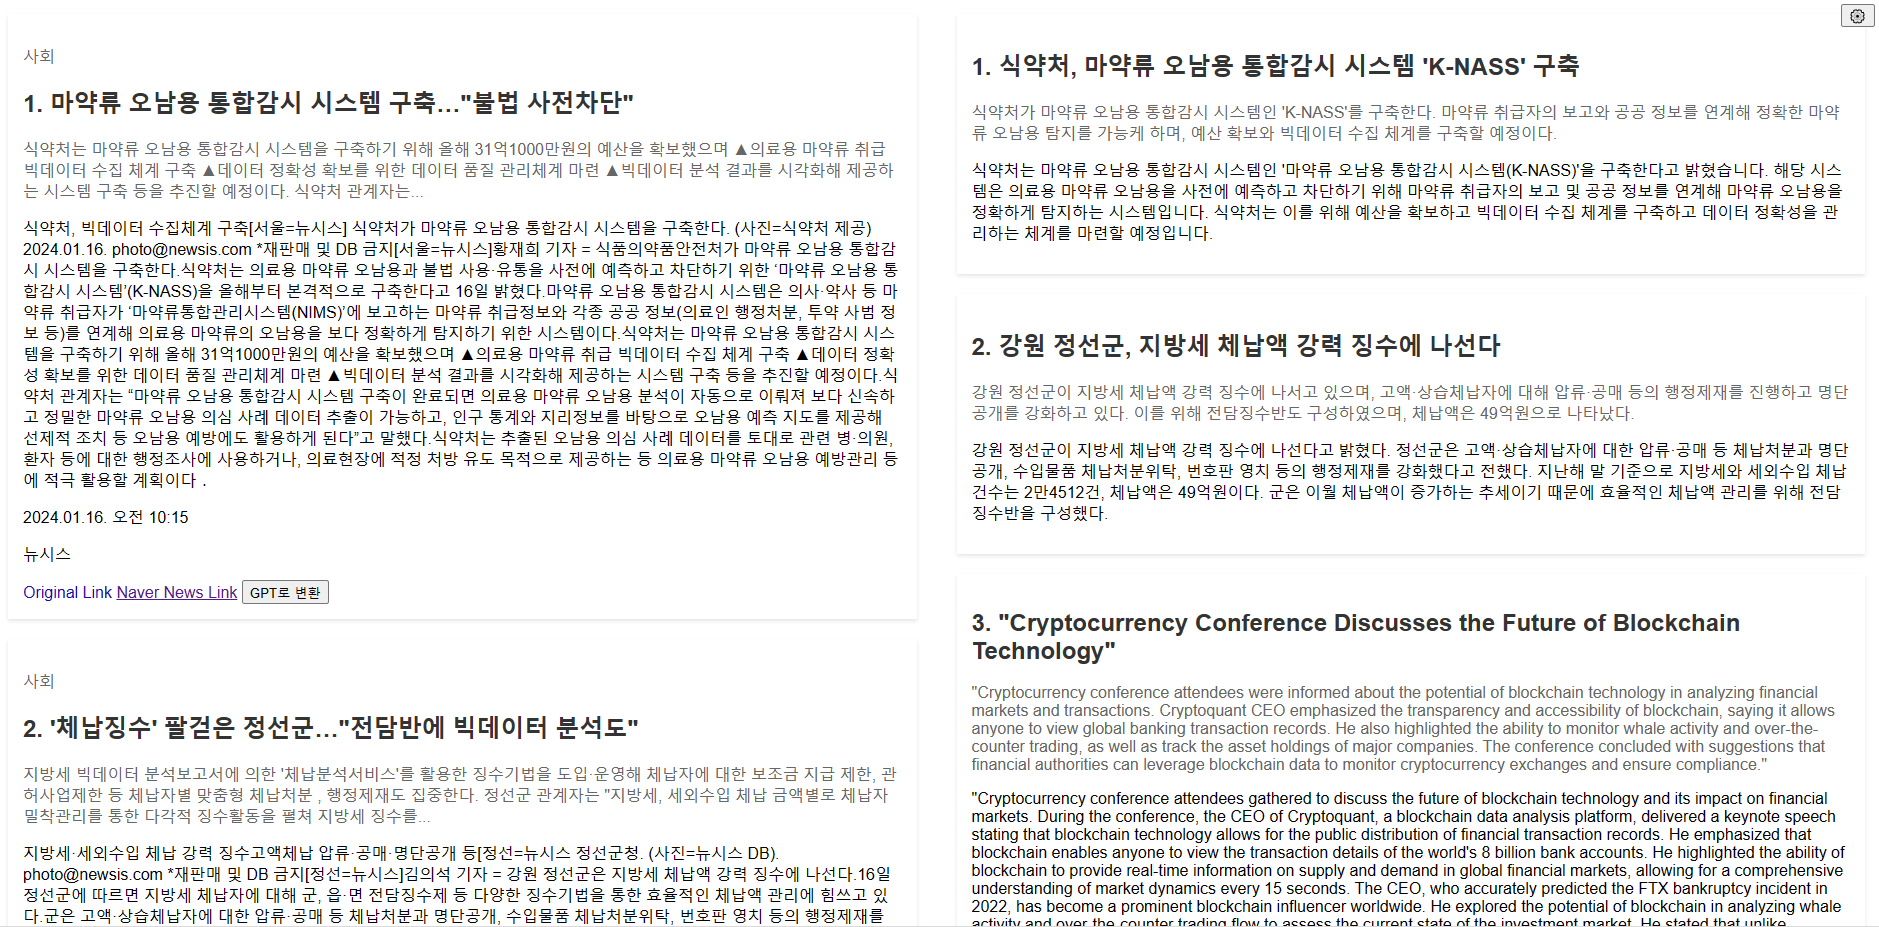

  
원본 뉴스 하단의 gpt로 변환 버튼을 누르면 왼쪽에 원본 뉴스, 오른쪽에는 gpt로 변환된 뉴스가 보여집니다.


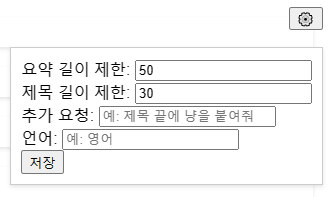   
페이지 우상단의 설정을 눌러 gpt로 변환시 옵션을 조정할 수 있습니다.   
단 길이 제한이 뉴스 내용에 비해 짧다고 gpt가 판단할 시 길이 제한을 무시하는 경향이 있습니다.   
또한 추가요청이 본문에 큰 영향을 끼치는 경우 요청이 무시될 수 있습니다.